In [136]:
import pandas as pd
from collections import defaultdict
from datetime import datetime

In [138]:
data = pd.read_csv(
    filepath_or_buffer = '../../datasets/electricity/full_data.csv',
    names = ["Date"] + list(range(1,371)),
    sep=";",
    header=0,
    index_col="Date",
    dtype=defaultdict(lambda:"float", {"Date":"string"}),
    decimal=","
) 
data.index = pd.to_datetime(data.index)
data = data[data.index > "2012-01-01"].resample("1h").ffill().dropna()

In [142]:
data.iloc[0] != 0

1       True
2       True
3       True
4       True
5       True
       ...  
366     True
367     True
368     True
369     True
370    False
Name: 2012-01-01 01:00:00, Length: 370, dtype: bool

In [148]:
data[data.columns[data.iloc[0] != 0]]

,1,2,3,4,5,6,7,8,9,10,...,360,361,362,363,364,365,366,367,368,369
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,68.181818,88.172043,...,200.657895,112.062812,23800.0,1324.894515,1636.363636,15.645372,14.628438,539.947322,63.439065,693.548387
2012-01-01 02:00:00,6.345178,24.893314,77.324066,136.178862,67.073171,336.309524,7.914076,282.828283,68.181818,79.569892,...,205.043860,112.776588,24100.0,1071.729958,1636.363636,15.645372,11.702750,564.530290,58.430718,684.017595
2012-01-01 03:00:00,3.807107,22.759602,77.324066,126.016260,63.414634,244.047619,6.783493,218.855219,55.944056,69.892473,...,202.850877,94.932191,24100.0,1067.510549,1636.363636,16.949153,9.362200,369.622476,46.744574,679.618768
2012-01-01 04:00:00,5.076142,22.048364,77.324066,93.495935,53.658537,169.642857,3.391747,188.552189,45.454545,46.236559,...,200.657895,64.239829,23000.0,1016.877637,1590.909091,26.075619,11.117613,376.646181,43.405676,670.821114
2012-01-01 05:00:00,3.807107,22.048364,77.324066,77.235772,45.121951,145.833333,3.391747,178.451178,43.706294,39.784946,...,199.561404,82.798001,22000.0,1033.755274,1568.181818,15.645372,8.191925,315.188762,45.075125,692.082111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,1.269036,26.315789,1.737619,195.121951,96.341463,366.071429,11.305822,340.067340,99.650350,84.946237,...,458.333333,339.757316,38000.0,1877.637131,2227.272727,73.011734,5.851375,482.001756,41.736227,689.882698
2014-12-31 21:00:00,1.269036,22.759602,1.737619,162.601626,87.804878,327.380952,11.305822,265.993266,83.916084,73.118280,...,258.771930,323.340471,37100.0,1654.008439,1613.636364,71.707953,4.681100,336.259877,131.886477,659.090909
2014-12-31 22:00:00,1.269036,22.048364,1.737619,164.634146,93.902439,315.476190,11.305822,262.626263,71.678322,68.817204,...,207.236842,323.340471,37000.0,1645.569620,1409.090909,66.492829,6.436513,521.510097,173.622705,658.357771


In [140]:
data

,1,2,3,4,5,6,7,8,9,10,...,361,362,363,364,365,366,367,368,369,370
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,68.181818,88.172043,...,112.062812,23800.0,1324.894515,1636.363636,15.645372,14.628438,539.947322,63.439065,693.548387,0.000000
2012-01-01 02:00:00,6.345178,24.893314,77.324066,136.178862,67.073171,336.309524,7.914076,282.828283,68.181818,79.569892,...,112.776588,24100.0,1071.729958,1636.363636,15.645372,11.702750,564.530290,58.430718,684.017595,0.000000
2012-01-01 03:00:00,3.807107,22.759602,77.324066,126.016260,63.414634,244.047619,6.783493,218.855219,55.944056,69.892473,...,94.932191,24100.0,1067.510549,1636.363636,16.949153,9.362200,369.622476,46.744574,679.618768,0.000000
2012-01-01 04:00:00,5.076142,22.048364,77.324066,93.495935,53.658537,169.642857,3.391747,188.552189,45.454545,46.236559,...,64.239829,23000.0,1016.877637,1590.909091,26.075619,11.117613,376.646181,43.405676,670.821114,0.000000
2012-01-01 05:00:00,3.807107,22.048364,77.324066,77.235772,45.121951,145.833333,3.391747,178.451178,43.706294,39.784946,...,82.798001,22000.0,1033.755274,1568.181818,15.645372,8.191925,315.188762,45.075125,692.082111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,1.269036,26.315789,1.737619,195.121951,96.341463,366.071429,11.305822,340.067340,99.650350,84.946237,...,339.757316,38000.0,1877.637131,2227.272727,73.011734,5.851375,482.001756,41.736227,689.882698,8594.594595
2014-12-31 21:00:00,1.269036,22.759602,1.737619,162.601626,87.804878,327.380952,11.305822,265.993266,83.916084,73.118280,...,323.340471,37100.0,1654.008439,1613.636364,71.707953,4.681100,336.259877,131.886477,659.090909,7837.837838
2014-12-31 22:00:00,1.269036,22.048364,1.737619,164.634146,93.902439,315.476190,11.305822,262.626263,71.678322,68.817204,...,323.340471,37000.0,1645.569620,1409.090909,66.492829,6.436513,521.510097,173.622705,658.357771,7891.891892


In [109]:
train_data = data[data.index <= "2014-10-01"]
val_data = data[data.index > "2014-10-01"]

In [129]:
l = data.ne(0).idxmax()

In [117]:
l.iloc[0] 

Timestamp('2012-01-01 01:00:00')

In [135]:
len(l[l > "2012-01-15"])

49

In [110]:
val_data

,1,2,3,4,5,6,7,8,9,10,...,361,362,363,364,365,366,367,368,369,370
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-01 00:00:00,2.538071,24.893314,1.737619,113.821138,46.341463,133.928571,4.522329,232.323232,68.181818,59.139785,...,117.059243,30200.0,1194.092827,1295.454545,140.808344,6.436513,806.848112,183.639399,809.384164,21297.297297
2014-10-01 01:00:00,1.269036,21.337127,1.737619,113.821138,40.243902,127.976190,2.826456,191.919192,52.447552,56.989247,...,44.967880,14500.0,852.320675,1045.454545,66.492829,4.681100,770.851624,173.622705,756.598240,22378.378378
2014-10-01 02:00:00,2.538071,19.203414,1.737619,99.593496,37.804878,119.047619,3.391747,178.451178,54.195804,53.763441,...,39.971449,12900.0,729.957806,1000.000000,69.100391,4.681100,730.465320,118.530885,717.741935,22594.594595
2014-10-01 03:00:00,2.538071,18.492176,1.737619,91.463415,34.146341,104.166667,2.826456,164.983165,52.447552,54.838710,...,37.830121,11800.0,738.396624,863.636364,69.100391,4.681100,649.692713,118.530885,731.671554,22702.702703
2014-10-01 04:00:00,2.538071,19.203414,1.737619,81.300813,35.365854,110.119048,3.391747,212.121212,48.951049,52.688172,...,35.688794,11600.0,751.054852,886.363636,66.492829,7.606788,639.157155,93.489149,725.073314,18648.648649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,1.269036,26.315789,1.737619,195.121951,96.341463,366.071429,11.305822,340.067340,99.650350,84.946237,...,339.757316,38000.0,1877.637131,2227.272727,73.011734,5.851375,482.001756,41.736227,689.882698,8594.594595
2014-12-31 21:00:00,1.269036,22.759602,1.737619,162.601626,87.804878,327.380952,11.305822,265.993266,83.916084,73.118280,...,323.340471,37100.0,1654.008439,1613.636364,71.707953,4.681100,336.259877,131.886477,659.090909,7837.837838
2014-12-31 22:00:00,1.269036,22.048364,1.737619,164.634146,93.902439,315.476190,11.305822,262.626263,71.678322,68.817204,...,323.340471,37000.0,1645.569620,1409.090909,66.492829,6.436513,521.510097,173.622705,658.357771,7891.891892


In [99]:
140256 - 105216

35040

In [98]:
k = data.resample("1h").ffill().dropna()
k = k[k.index > "2014-01-1"]
k.iloc[:5833]

,1,2,3,4,5,6,7,8,9,10,...,361,362,363,364,365,366,367,368,369,370
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,2.538071,23.470839,0.000000,136.178862,74.390244,252.976190,6.218202,249.158249,52.447552,72.043011,...,72.091363,14900.0,746.835443,909.090909,18.252934,12.873025,232.660228,50.083472,695.747801,7243.243243
2014-01-01 02:00:00,2.538071,25.604552,0.000000,148.373984,73.170732,211.309524,5.087620,242.424242,52.447552,67.741935,...,68.522484,15300.0,582.278481,909.090909,16.949153,13.458163,215.978929,51.752922,649.560117,6594.594595
2014-01-01 03:00:00,2.538071,22.048364,0.000000,119.918699,67.073171,196.428571,6.218202,218.855219,47.202797,56.989247,...,68.522484,14500.0,578.059072,863.636364,16.949153,9.947338,182.616330,45.075125,676.686217,6702.702703
2014-01-01 04:00:00,2.538071,22.048364,0.000000,117.886179,54.878049,166.666667,5.652911,202.020202,45.454545,53.763441,...,68.522484,13500.0,565.400844,863.636364,16.949153,8.191925,178.226514,46.744574,673.020528,6486.486486
2014-01-01 05:00:00,2.538071,21.337127,0.000000,103.658537,64.634146,145.833333,3.957038,175.084175,47.202797,51.612903,...,77.801570,13400.0,556.962025,840.909091,15.645372,12.287888,200.175593,45.075125,683.284457,6432.432432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-31 21:00:00,15.228426,34.139403,1.737619,156.504065,56.097561,190.476190,5.087620,289.562290,68.181818,59.139785,...,669.521770,110100.0,4894.514768,7113.636364,100.391134,9.947338,489.025461,50.083472,832.844575,20810.810811
2014-08-31 22:00:00,16.497462,32.716927,1.737619,140.243902,69.512195,181.547619,3.957038,272.727273,52.447552,56.989247,...,552.462527,101700.0,3333.333333,6931.818182,100.391134,4.095963,576.821773,48.414023,783.724340,24270.270270
2014-08-31 23:00:00,16.497462,32.716927,1.737619,134.146341,59.756098,208.333333,5.652911,249.158249,47.202797,50.537634,...,215.560314,80300.0,2371.308017,3636.363636,99.087353,4.681100,680.421422,48.414023,763.196481,19297.297297


In [73]:
k = data[data.index > "2014-01-11"].resample("1h",on="Date").ffill()
k = k[k.index < "2014-03-19 09:00:00"]
k

KeyError: 'The grouper name Date is not found'

In [68]:
len(k)

6468

<AxesSubplot: xlabel='Date'>

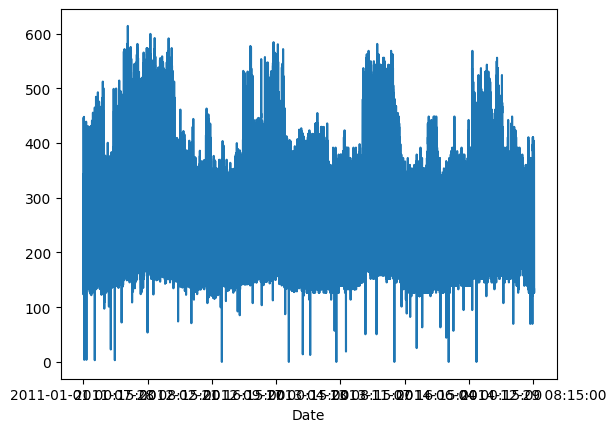

In [34]:
data.iloc[:,200].plot()

In [10]:
data.rename(columns={"Unnamed: 0":"Date"}).set_index("Date")

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,"2,53807106598985","22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182","72,0430107526882",...,"276,945039257673",28200.0,"1616,03375527426","1363,63636363636","29,986962190352","5,85137507314219","697,102721685689","176,961602671119","651,026392961877","7621,62162162162"
2014-12-31 23:15:00,"2,53807106598985","21,3371266002845","1,73761946133797","166,666666666667","81,7073170731707","324,404761904762","11,3058224985868","252,525252525253","64,6853146853147","72,0430107526882",...,"279,800142755175",28300.0,"1569,62025316456","1340,90909090909","29,986962190352","9,94733762434172","671,641791044776","168,614357262104","669,354838709677","6702,7027027027"
2014-12-31 23:30:00,"2,53807106598985","20,6258890469417","1,73761946133797","162,60162601626","82,9268292682927","318,452380952381","10,1752402487281","242,424242424242","61,1888111888112","74,1935483870968",...,"284,796573875803",27800.0,"1556,96202531646","1318,18181818182","27,3794002607562","9,3622001170275","670,763827919227","153,589315525876","670,087976539589","6864,86486486487"


In [36]:
26304*4

105216

In [59]:
k = data[data.index > "2014-01-01"]

k = data.iloc[140256 - 105216][data.iloc[140256 - 105216] != 0]

In [53]:
k

1        3.807107
2       22.759602
3       77.324066
4      136.178862
5       70.731707
          ...    
365     15.645372
366     12.873025
367    504.828797
368     63.439065
369    761.730205
Name: 2012-01-01 00:15:00, Length: 320, dtype: float64

In [54]:
data.iloc[140256 - 105000][data.iloc[140256 - 105000] != 0]

1        3.807107
2       31.294452
3        2.606429
4       77.235772
5       63.414634
          ...    
365     20.860495
366     43.885313
367    595.258999
368    121.869783
369    774.926686
Name: 2012-01-03 06:15:00, Length: 319, dtype: float64

In [55]:
26304*4/24

4384.0

In [57]:
5833*24 + 7*24

140160

In [159]:
a = [1,2,3,5,6]
a[-3:] = 5

TypeError: can only assign an iterable

In [154]:
pd.read_csv("../../datasets/electricity/train.csv").set_index("date")

,0,1,2,3,4,5,6,7,8,9,...,359,360,361,362,363,364,365,366,367,368
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,68.181818,88.172043,...,200.657895,112.062812,23800.0,1324.894515,1636.363636,15.645372,14.628438,539.947322,63.439065,693.548387
2012-01-01 02:00:00,6.345178,24.893314,77.324066,136.178862,67.073171,336.309524,7.914076,282.828283,68.181818,79.569892,...,205.043860,112.776588,24100.0,1071.729958,1636.363636,15.645372,11.702750,564.530290,58.430718,684.017595
2012-01-01 03:00:00,3.807107,22.759602,77.324066,126.016260,63.414634,244.047619,6.783493,218.855219,55.944056,69.892473,...,202.850877,94.932191,24100.0,1067.510549,1636.363636,16.949153,9.362200,369.622476,46.744574,679.618768
2012-01-01 04:00:00,5.076142,22.048364,77.324066,93.495935,53.658537,169.642857,3.391747,188.552189,45.454545,46.236559,...,200.657895,64.239829,23000.0,1016.877637,1590.909091,26.075619,11.117613,376.646181,43.405676,670.821114
2012-01-01 05:00:00,3.807107,22.048364,77.324066,77.235772,45.121951,145.833333,3.391747,178.451178,43.706294,39.784946,...,199.561404,82.798001,22000.0,1033.755274,1568.181818,15.645372,8.191925,315.188762,45.075125,692.082111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 20:00:00,1.269036,31.294452,1.737619,193.089431,60.975610,279.761905,5.087620,380.471380,103.146853,106.451613,...,861.842105,553.176303,82200.0,4548.523207,6977.272727,187.744459,8.191925,510.096576,188.647746,1016.129032
2014-09-30 21:00:00,2.538071,28.449502,1.737619,166.666667,63.414634,244.047619,5.652911,319.865320,103.146853,73.118280,...,930.921053,421.841542,87400.0,3320.675105,7045.454545,170.795306,4.095963,496.049166,207.011686,934.017595
2014-09-30 22:00:00,1.269036,27.027027,1.737619,156.504065,56.097561,252.976190,5.652911,282.828283,73.426573,66.666667,...,883.771930,247.680228,67900.0,3168.776371,6522.727273,166.883963,3.510825,574.187884,210.350584,854.838710
